# Compute  PCA

- try 3 methods :  NMF, FastICA, PCA

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab.in2p3.fr
- creation date : 2022/12/26
- last update : 2023/01/13

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
from sklearn.decomposition import NMF, FastICA, PCA

In [3]:
from astropy.io import fits

## Start

In [ ]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

## Read file

In [4]:
filename = 'datatools/pca_SL_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data

In [5]:
data_in

array([[0.00000000e+00, 9.10000000e+01, 9.40000000e+01, ...,
        9.95000000e+03, 9.97000000e+03, 9.99000000e+03],
       [0.00000000e+00, 4.97839069e-07, 5.52382959e-07, ...,
        7.06085364e-05, 7.06330908e-05, 7.05906948e-05],
       [0.00000000e+00, 1.19574179e-06, 1.27758431e-06, ...,
        4.46025945e-05, 4.46908296e-05, 4.46647757e-05],
       ...,
       [7.36000000e+02, 2.14675694e-06, 2.50389986e-06, ...,
        2.12861759e-05, 2.12363909e-05, 2.11664152e-05],
       [7.37000000e+02, 8.31448778e-07, 9.57832321e-07, ...,
        7.00733914e-05, 6.99426115e-05, 7.00519814e-05],
       [7.38000000e+02, 7.21010321e-08, 8.01113405e-08, ...,
        1.50517900e-04, 1.50795383e-04, 1.50744720e-04]])

In [6]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

In [7]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
flux = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [8]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_5231/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

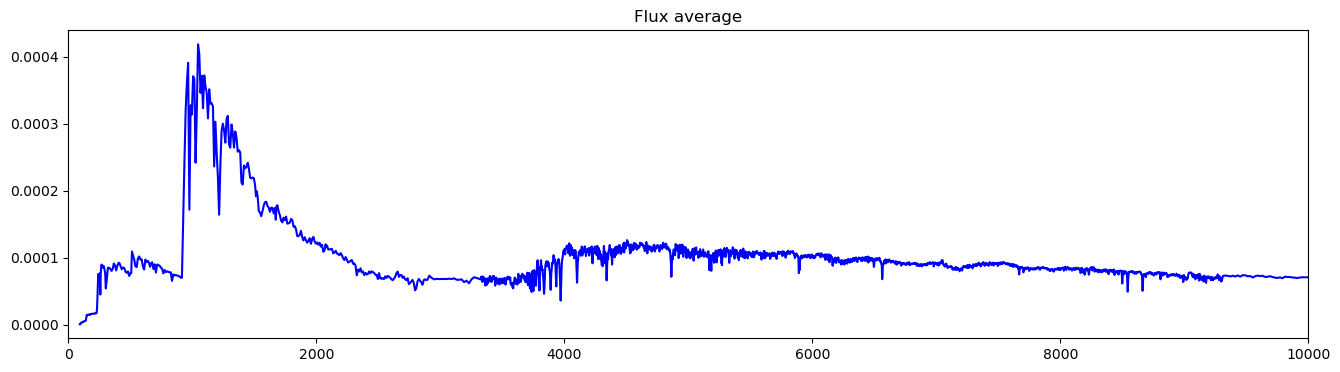

In [9]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

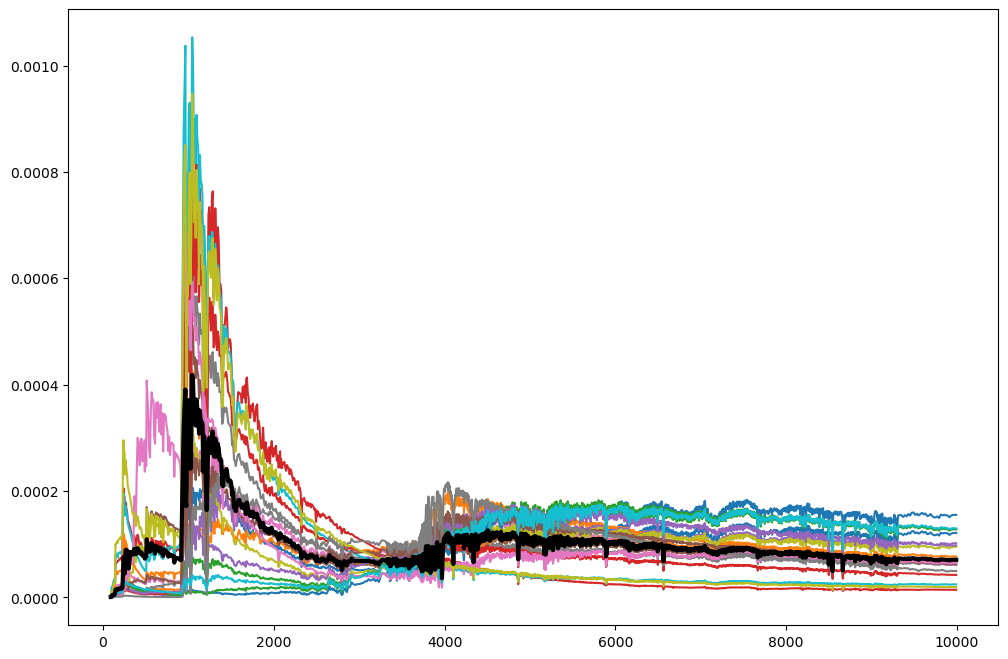

In [10]:
fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    
    plt.plot(wavelengths,flux[idx,:])
  
flux_mean = flux.mean(0)
plt.plot(wavelengths,flux_mean,"k-",lw=3)
#plt.ylim(0,50.)

In [11]:
#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
#  we'll save the results so that they can be re-used
@pickle_results('spec_decompositions.pkl')
def compute_PCA_ICA_NMF(n_components=5):
   

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(flux)
    #pca_comp = np.vstack([flambdas_average,
    #                      pca.components_])
    pca_comp = np.vstack([flambdas_average,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(flux.T)
    ica_comp = np.vstack([flambdas_average,
                          ica.transform(flux.T).T])

    # NMF requires all elements of the input to be greater than zero
    flux[flux < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(flux)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp


In [12]:
n_components = 20
decompositions = compute_PCA_ICA_NMF(n_components)

@pickle_results: using precomputed results from 'spec_decompositions.pkl'


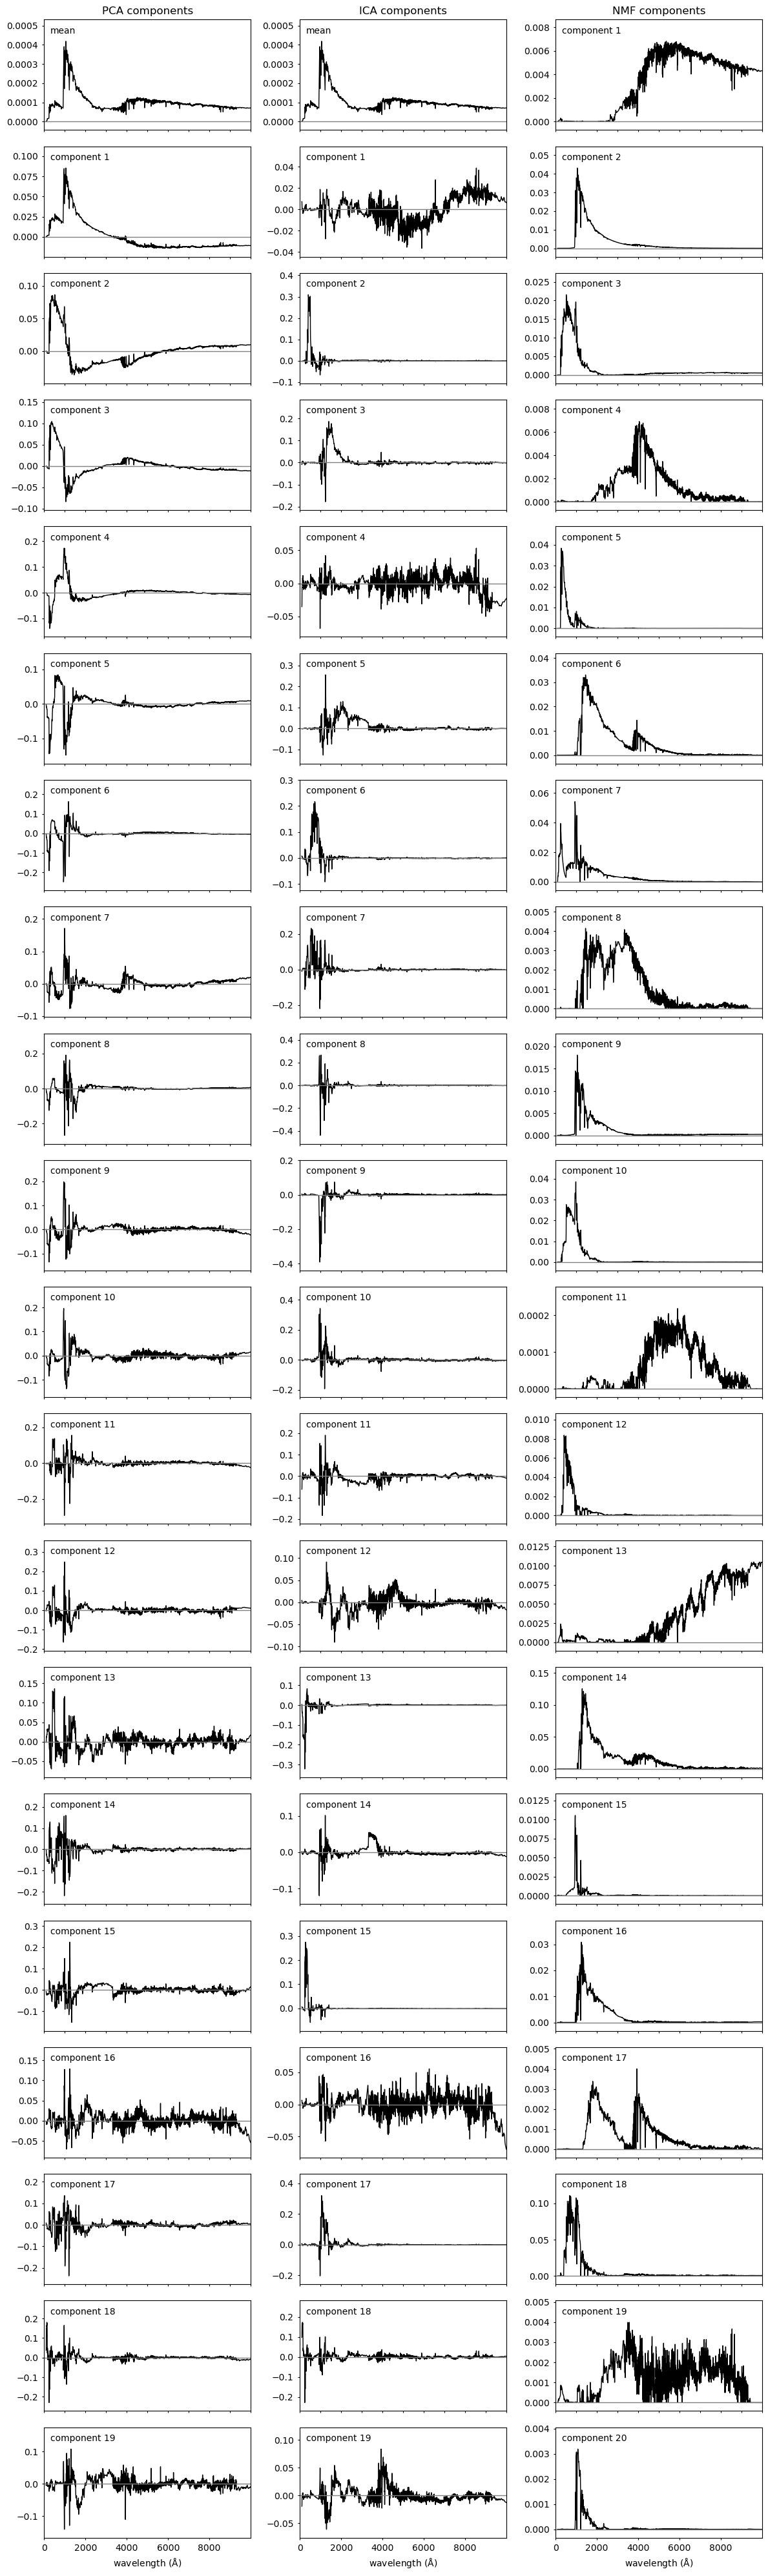

In [13]:
#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 40))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        #ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(0, 10000, 2000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [0, 10000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)

plt.tight_layout()
plt.show()
